In [9]:
import numpy as np
pi = np.pi
pi2i = pi*2j
from matplotlib import pyplot as plt

In [10]:
def line(x0,y0,x1,y1,n=32):
    '''
    return a numpy array of n points from (x0,y0) to (x1,y1)
    '''
    X = np.linspace(x0,x1,n)
    Y = np.linspace(y0,y1,n)
    return np.array([X,Y])

def cplx2tuple(z):
    return np.real(z), np.imag(z)

# intro
I solved the interior 2d stokes problem on the circle in this jupyter notebook, which serves as a basis for further solution of this problem

In [11]:
# number of points
n = 1000

# parameter of the curve
a = np.linspace(0,2*np.pi,n+1)[:-1]
h = 2*np.pi / n

# complex coordinates of points 
t = np.exp(a*1j)

# parametrization derivatives
t_dt = t*1j

# boundary conditions
v = np.zeros(n)
u = 1-(t.imag)**2
h2 = u
h1 = -v
# H = h1 + h2*1j
H = np.ones(n)

# curvature
curvature = np.ones(n)

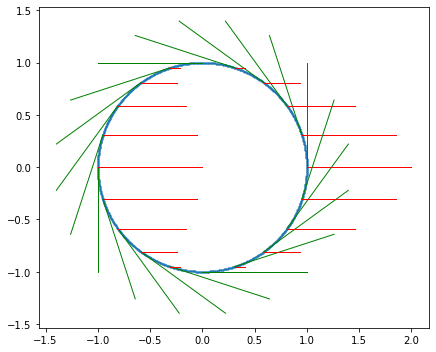

In [12]:
fig, ax = plt.subplots(figsize=(7,7))

plt.scatter(np.real(t), np.imag(t), s=1)

for i in range(0,n,n//20):
    x,y = cplx2tuple(t[i])
    ux,uy = cplx2tuple(u[i]) 
    tx,ty = cplx2tuple(t_dt[i])

    plt.plot(*line(x,y,x+tx,y+ty),c='g',linewidth=1)
    plt.plot(*line(x,y,x+ux,y+uy),c='r',linewidth=1)
    
ax.set_aspect(1)

the blue dots is equal-space pts on the boundary $\Gamma=S^1$, the red line is vector field of velocity, the green line is the tangential derivatives. the yellow line is the normal derivatives


The velocity is the normalized presoille flow with integration = 1

The kernels and BI eq can be greatly simplified in this specific case, compare to the original case in L. Greengard's paper. In this case, it is 

$$
K_1'(t_i,t_j) = \frac{-h}{\pi} \Im(\frac{d_j}{dt})\\
K_2'(t_i,t_j) = \frac{-h}{2\pi i} (\frac{-d_j}{\bar{dt}} + \frac{\bar{d_j}dt}{\bar{dt}^2}) 
$$ 
where $dt = t_i-t_j$, $d_j$ is the derivative of the parametrization. 

And in the limiting case of $i=j$, the kernels should be 

$$
K_1'(t_i,t_i) = \frac{h}{2\pi}\kappa_i |d_i| \\
K_2'(t_i,t_i) = \frac{-h}{2\pi} \kappa_i d_i^2/ |d_i|
$$

In [13]:
def K1_func(i,j):
    if i == j:
        k = curvature[i]
        d = np.abs(t_dt[i])
        return h*k*d/(2*np.pi)
    dt = t[i] - t[j]
    d = t_dt[j]
    return -h*np.imag(d/dt)/np.pi

def K2_func(i,j):
    if i==j:
        k = curvature[i]
        d = np.abs(t_dt[i])
        return h*k*d/(2*np.pi)
    d = t_dt[j]
    dt = t[i] - t[j]
    return -h/(2j*pi) * (-d/np.conjugate(dt) + np.conjugate(d)*dt/np.conjugate(dt**2))

In [14]:
dt = t[:,np.newaxis] - t[np.newaxis,:]
with np.errstate(divide='ignore', invalid='ignore'):
    temp = t_dt[np.newaxis,:] / dt
    temp = temp.imag
    K1 = -h/pi * temp
    K2 = -h/(2j*pi) * (-t_dt[np.newaxis,:]/np.conjugate(dt) + np.conjugate(t_dt)[np.newaxis,:]*dt/np.conjugate(dt**2))
for i in range(n):
    K1[i,i] = K1_func(i,i)
    K2[i,i] = K2_func(i,i)

this calculation can be vectorized for speeding up, but I guess it needs to handle the case of i == j more carefully. 

My integral equation does not contain any singular term, this could lead to inaccuracy and convergence, I guess. 

Should I transfer this into a real equation for the solution?? Or is it I can just live with the complex equation? How to deal with the complex conjugates though... 

The integral equation is of the following form

$$
(I+K_1+K_2\mathfrak C) \omega = h
$$ where $\mathfrak C$ is a symbol for conjugation. 

This can be discreticized in the the points of our choice and then seperate the real and imaginary matrix equation so that 

$$
\begin{pmatrix}
I+\Re(K_1+K_2) & \Im(-K_1+K_2) \\
\Im(K_1 + K_2) & I+\Re(K_1-K_2)
\end{pmatrix}
\begin{pmatrix}
\Re \omega\\
\Im \omega
\end{pmatrix} = 
\begin{pmatrix}
\Re h\\
\Im h
\end{pmatrix}
$$

## Condition number of the matrix

In [15]:
A = np.zeros((2*n,2*n))
A[:n,:n] = np.identity(n) + (K1+K2).real
A[:n,n:] = (-K1+K2).imag
A[n:,:n] = (K1+K2).imag
A[n:,n:] = np.identity(n) + (K1-K2).real

In [8]:
np.linalg.cond(A)

2003.006010022094